In [1]:
%matplotlib inline
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 

import pandas as pd
import seaborn as sns; sns.set()
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix

In [2]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [3]:
# path to seed-to-voxel matrices

path_to_files = "/home/xlajoie/Desktop/Seeds2voxels_n100"

In [4]:
path_list = glob.glob("Seeds2voxels_n100/*_Seeds2Voxels.nii.gz")
path_list.sort()

In [5]:
# get only the npy files out of the Seeds2voxels folder which also has nii.gz files 

ls_sub = [(file) for file in os.listdir(path_to_files) if file[-3:] == "npy"]

x_correl = []
y_sex = []
for filename in ls_sub:
    sub_id = filename.split("_")[0]
    # if sub_id is in csv
    if len(df.loc[df['subject_label'] == int(sub_id)]) != 0:
        x_correl.append(np.load(os.path.join(path_to_files, filename)).flatten())
        y_sex.append(df.loc[df['subject_label'] == int(sub_id)]["Gender"].values[0])

x_correl = np.asarray(x_correl)
    

In [6]:
print(sum(y_sex), len(y_sex))

40 78


In [7]:
# split the sample o training/test with a 80/20 % ratio 
# and stratify sex by class, also shuffle the data

X_train, X_test, y_train, y_test = train_test_split( 
                                                    x_correl,  # x 
                                                    y_sex,       # y 
                                                    test_size = 0.2, # 80%/20% split 
                                                    shuffle = True,  #shuffle dataset before splitting
                                                    stratify = y_sex,  # keep distribution of sex_class consistent between train and test sets
                                                    random_state = 123) #same shuffle each time 

print('train:', len(X_train),'test:', len(X_test))




train: 62 test: 16


In [13]:
# comparing different # of features for find how many explain the most variance 

score = []
max_feature = int(0.9*len(X_train))
n_components_range = range(0, max_feature, 10) # A range of different values for n_components

for n_comp in tqdm(n_components_range):
    if n_comp == 0:
        model = LinearSVC(max_iter=2000)
    else:
        model = Pipeline([
            ('feature_selection', PCA(n_comp)),
            ('prediction', LinearSVC(max_iter=2000))
                      ])
    #score = cross_val_score(model, X_train, y_train, cv=10)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3).mean())


100%|█████████████████████████████████████████████| 6/6 [08:38<00:00, 86.46s/it]


In [14]:
print(score)
x = list(n_components_range)

[0.6928571428571428, 0.6309523809523809, 0.6761904761904762, 0.6595238095238095, 0.6428571428571429, 0.6238095238095239]


Text(0, 0.5, 'Cross_val Score')

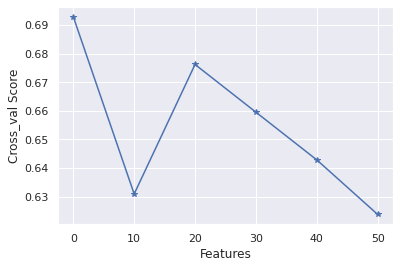

In [16]:
plt.plot(x,score, color = "b", marker = "*")
plt.xlabel("Features")
plt.ylabel("Cross_val Score")

In [18]:
best_ncomp = n_components_range[np.array(score).argmax()]
best_ncomp

0

In [19]:
# Now that we know how many features explain the most variance, we can put the number here 

pca = PCA(n_components=5)  #top 5 which explain the most variance found from the 
pca.fit(x_correl)
X_features = pca.transform(x_correl)
#print(X_features)

In [21]:
if best_ncomp == 0:
    model = LinearSVC(max_iter=2000)
else:
    model = Pipeline([
            ('feature_selection', PCA(best_ncomp)),
            ('prediction', LinearSVC(max_iter=2000))
                      ])
model.fit(X_train,y_train) #fit the model/ train the model
y_pred = model.predict(X_test)

#calculate the model accuracy
acc = model.score(X_test, y_test)

#compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
df = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
print(df.head())

# print results
print('accuracy (r2) =', acc)



       Positive  Negative
True          6         2
False         0         8
accuracy (r2) = 0.875


In [62]:
df = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
df

,Positive,Negative
True,6,2
False,0,8


In [73]:
model.get_params()

{'memory': None,
 'steps': [('feature_selection', PCA(n_components=5)),
  ('prediction', LinearSVC(max_iter=2000))],
 'verbose': False,
 'feature_selection': PCA(n_components=5),
 'prediction': LinearSVC(max_iter=2000),
 'feature_selection__copy': True,
 'feature_selection__iterated_power': 'auto',
 'feature_selection__n_components': 5,
 'feature_selection__random_state': None,
 'feature_selection__svd_solver': 'auto',
 'feature_selection__tol': 0.0,
 'feature_selection__whiten': False,
 'prediction__C': 1.0,
 'prediction__class_weight': None,
 'prediction__dual': True,
 'prediction__fit_intercept': True,
 'prediction__intercept_scaling': 1,
 'prediction__loss': 'squared_hinge',
 'prediction__max_iter': 2000,
 'prediction__multi_class': 'ovr',
 'prediction__penalty': 'l2',
 'prediction__random_state': None,
 'prediction__tol': 0.0001,
 'prediction__verbose': 0}

In [ ]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ['input1', 'input2']
svm = svm.SVC(kernel='linear')
svm.fit(X, Y)
f_importances(svm.coef_, features_names)

In [48]:
coef = model[1].coef_
coef = model[0].inverse_transform(coef)

In [50]:
coef.shape

(1, 1546952)

In [51]:
coef

array([[0.05441109, 0.07336142, 0.10004145, ..., 0.15724532, 0.1098592 ,
        0.10328962]])

In [67]:
coef_max = []
for i in range(0, len(coef[0])):
    if coef[0][i] >= 0.6:
        coef_max.append(coef[0][i])

In [74]:
coef_max = np.asarray(coef_max)